In [63]:
import ta
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from fredapi import Fred
from datetime import datetime
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow import *
from keras import Sequential
from keras.layers import Dense,LSTM, Dropout
import warnings

warnings.filterwarnings('ignore', category=UserWarning)


import os 

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

today = datetime.today().strftime('%Y-%m-%d')

In [64]:
file_path = '../data/tech_df.csv'  # 파일 경로 및 파일명
tech_df = pd.read_csv(file_path)

file_path = '../data/fund_df.csv'  # 파일 경로 및 파일명
fund_df = pd.read_csv(file_path)


df = pd.merge(tech_df, fund_df, on = 'Date')
df = df.drop(columns='Adj Close_y')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.rename(columns={'Adj Close_x' : 'y'})
df = df.dropna()

df

,Open,High,Low,Close,y,Volume,MA5,MA20,MA60,MA120,...,DJI Adj Close,DJI Volume,NDAQ Adj Close,NDAQ Volume,SPX Adj Close,SPX Volume,RUT Adj Close,RUT Volume,Information Technology Adj Close,Information Technology Volume
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-21,18.997499,19.062500,18.797501,19.031071,16.720797,374046400,16.636831,16.604621,16.718677,16.532836,...,16302.769531,353670000,4276.790039,3245740000,1866.520020,5270710000,1193.729980,5270710000,83.319122,259800
2014-03-24,19.229286,19.303572,19.109285,19.256786,16.919113,355700800,16.714965,16.622883,16.705549,16.550624,...,16276.690430,110620000,4226.390137,2434650000,1857.439941,3409000000,1178.229980,3409000000,82.875786,1612900
2014-03-25,19.339287,19.491072,19.271070,19.463928,17.101107,282293200,16.800251,16.658859,16.697414,16.567032,...,16367.879883,89110000,4234.270020,2270760000,1865.619995,3200560000,1178.050049,3200560000,83.328163,636000
2014-03-26,19.518572,19.607143,19.245001,19.277857,16.937630,299768000,16.853720,16.694050,16.688535,16.581665,...,16268.990234,92770000,4173.580078,2455460000,1852.560059,3480850000,1155.489990,3480850000,82.115791,585600
2014-03-27,19.286428,19.339287,19.111429,19.195000,16.864832,222031600,16.908696,16.709410,16.681338,16.597280,...,16264.230469,93650000,4151.229980,2270650000,1849.040039,3733430000,1151.439941,3733430000,81.645309,471100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-11,221.460007,223.089996,217.889999,222.660004,222.660004,44587100,221.376004,224.682500,221.022990,200.957881,...,40861.710938,356040000,17395.529297,6086930000,5554.129883,3839450000,2103.850098,3839450000,561.580017,482900
2024-09-12,222.500000,223.550003,219.820007,222.770004,222.770004,37498200,221.454004,224.735001,221.128831,201.389797,...,41096.769531,289300000,17569.679688,4983120000,5595.759766,3655070000,2129.429932,3655070000,565.900024,417800
2024-09-13,223.580002,224.039993,221.910004,222.500000,222.500000,36766600,221.790002,224.624001,221.269794,201.811900,...,41393.781250,276800000,17683.980469,4802880000,5626.020020,3500790000,2182.489990,3500790000,569.239990,313100


In [65]:
df = df.dropna()
df.isnull().sum() 

## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# Create feature_df, label_df 
feature_cols = df.columns.drop('y').tolist()
label_cols = [ 'y' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transform
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2623, 37)
label_np.shape:(2623, 1)


In [66]:
## 1.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

train_split = int(len(X) * 0.80)  # 80% for training
val_split = int(len(X) * 0.90)  # 10% for validation (next 10% after training)

# Train set
x_train = X[:train_split]
y_train = Y[:train_split]

# Validation set
x_val = X[train_split:val_split]
y_val = Y[train_split:val_split]

# Test set
x_test = X[val_split:]
y_test = Y[val_split:]

# Shape 확인
print(f'X.shape: {X.shape}, Y.shape: {Y.shape}')
print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}')
print(f'x_val.shape: {x_val.shape}, y_val.shape: {y_val.shape}')
print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')

X.shape: (2593, 30, 37), Y.shape: (2593, 1)
x_train.shape: (2074, 30, 37), y_train.shape: (2074, 1)
x_val.shape: (259, 30, 37), y_val.shape: (259, 1)
x_test.shape: (260, 30, 37), y_test.shape: (260, 1)


In [67]:
## 1.4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=True, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=True 
               ))
model.add(Dropout(0.2))


model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False
               ))
model.add(Dropout(0.2))


model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_val)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,225 (360.25 KB)

 Trainable params: 92,225 (360.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.1889 - mae: 0.1201 - val_loss: 0.1508 - val_mae: 0.0604
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1449 - mae: 0.0460 - val_loss: 0.1284 - val_mae: 0.0394
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1240 - mae: 0.0341 - val_loss: 0.1137 - val_mae: 0.0612
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1064 - mae: 0.0300 - val_loss: 0.0962 - val_mae: 0.0491
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0909 - mae: 0.0270 - val_loss: 0.0806 - val_mae: 0.0322
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0775 - mae: 0.0250 - val_loss: 0.0688 - val_mae: 0.0299
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0664 - mae: 0.0257 - val_loss: 0.0591 - val_mae: 0.0318
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0568 - mae: 0.0235 - val_loss: 0.0506 - val_mae: 0.0287
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/

In [68]:
# Inverse transformation for y_val and pred
inverse_df = pd.DataFrame(np.zeros((len(y_val), len(scale_cols))), columns=scale_cols)
inverse_df['y'] = y_val.flatten()
real_y_val = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('y')]

inverse_df['y'] = pred.flatten()
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('y')]

# Validation set에 해당하는 날짜 계산
# train_split부터 val_split 사이의 날짜를 사용
dates = df.index[train_split + window_size: val_split + window_size].values  # validation 기간의 날짜 추출

# Validation 결과 DataFrame 생성
tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_val,
    'Predicted Price': real_pred
})

tech_result_df

,Date,Real Price,Predicted Price
0,2022-08-19,169.640411,169.345810
1,2022-08-22,165.733688,170.067099
2,2022-08-23,165.397415,170.069506
3,2022-08-24,165.694138,169.477486
4,2022-08-25,168.166748,168.568716
...,...,...,...
254,2023-08-28,179.272644,166.765305
255,2023-08-29,183.182632,167.632179
256,2023-08-30,186.694672,168.794685
257,2023-08-31,186.913528,170.340339


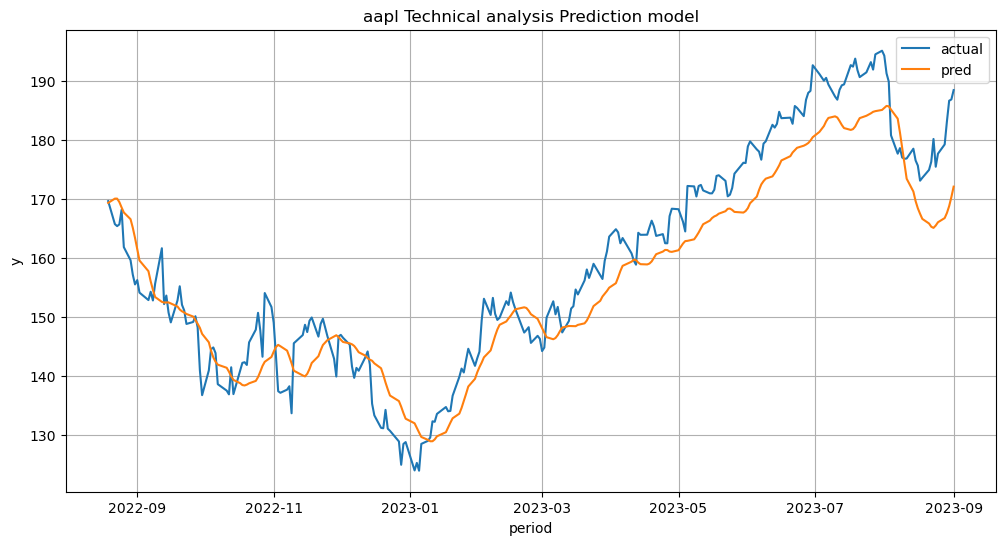

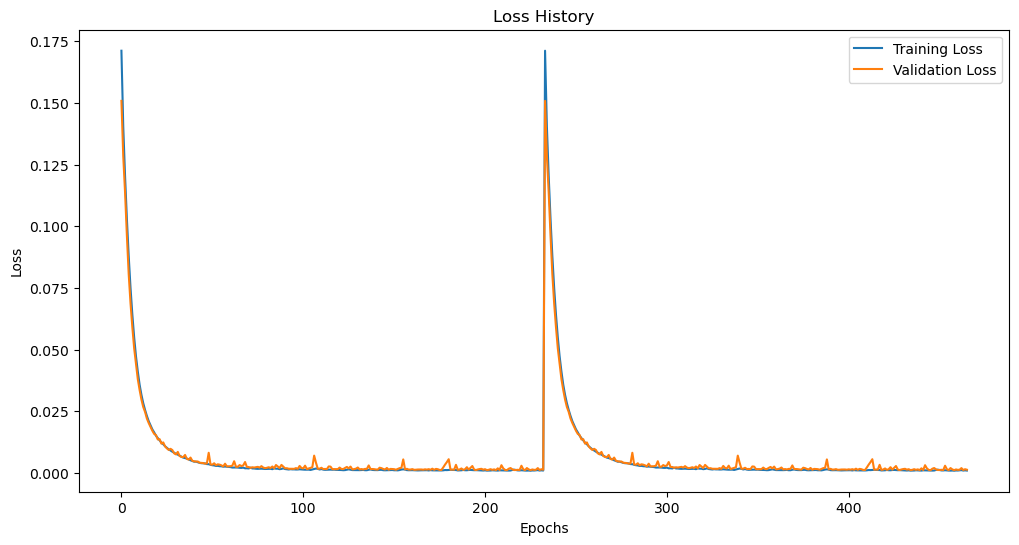

  Metrics    Values
0    MAPE  0.037432
1     MAE  0.024847
2    RMSE  0.029079


In [70]:
ticker = 'aapl'
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Technical analysis Prediction model')
plt.ylabel('y')
plt.xlabel('period')
plt.plot(tech_result_df['Date'], tech_result_df['Real Price'], label='actual')
plt.plot(tech_result_df['Date'], tech_result_df['Predicted Price'], label='pred')
plt.grid()
plt.legend(loc='best')
plt.show()

# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation 2: MAPE, MAE, RMSE
mape = np.sum(abs(y_val - pred) / y_val) / len(x_val)
mae = np.mean(np.abs(y_val - pred))
rmse = np.sqrt(np.mean(np.square(y_val - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

In [72]:
# NaN 값 제거
df = df.dropna()

# MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

# 입력 시퀀스 및 라벨 생성 함수 (window_size만큼 학습, prediction_size만큼 예측)
def make_sequence_dataset(feature, label, window_size, prediction_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature) - window_size - prediction_size + 1):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size:i+window_size+prediction_size]) 
    return np.array(feature_list), np.array(label_list) 

# Feature와 Label 설정
feature_cols = df.columns.drop('y').tolist()
label_cols = ['y']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# Numpy 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

# Window size 및 Prediction size 설정
window_size = 30  # 학습할 입력 데이터 길이
prediction_size = 30  # 예측할 출력 데이터 길이

# 입력 데이터 생성
X, Y = make_sequence_dataset(feature_np, label_np, window_size, prediction_size)

# 데이터 분할
train_split = int(len(X) * 0.80)
val_split = int(len(X) * 0.90)

# Train, Validation, Test set 분리
x_train = X[:train_split]
y_train = Y[:train_split]

x_val = X[train_split:val_split]
y_val = Y[train_split:val_split]

x_test = X[val_split:]
y_test = Y[val_split:]

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=True, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

# 예측할 일 수만큼 출력 설정
model.add(Dense(prediction_size, activation='linear'))

# 모델 컴파일
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# 모델 요약
model.summary()

# 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# 모델 학습
hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val),
                 epochs=1000, batch_size=150,       
                 callbacks=[early_stop]) 

# 예측 수행
pred = model.predict(x_val)

# 예측 결과 출력
print(pred)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 64)         │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,110 (367.62 KB)

 Trainable params: 94,110 (367.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.2173 - mae: 0.1690 - val_loss: 0.1611 - val_mae: 0.1315
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.1411 - mae: 0.0746 - val_loss: 0.1301 - val_mae: 0.1213
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1120 - mae: 0.0526 - val_loss: 0.1086 - val_mae: 0.1259
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0895 - mae: 0.0465 - val_loss: 0.0812 - val_mae: 0.0907
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0711 - mae: 0.0424 - val_loss: 0.0635 - val_mae: 0.0793
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0556 - mae: 0.0378 - val_loss: 0.0511 - val_mae: 0.0788
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0442 - mae: 0.0378 - val_loss: 0.0457 - val_mae: 0.0986
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0347 - mae: 0.0368 - val_loss: 0.0390 - val_mae: 0.1014
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/

In [73]:
# Inverse transformation for y_val and pred
inverse_df = pd.DataFrame(np.zeros((len(y_val), len(scale_cols))), columns=scale_cols)
inverse_df['y'] = y_val.flatten()
real_y_val = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('y')]

inverse_df['y'] = pred.flatten()
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('y')]

# Validation set에 해당하는 날짜 계산
# train_split부터 val_split 사이의 날짜를 사용
dates = df.index[train_split + window_size: val_split + window_size].values  # validation 기간의 날짜 추출

# Validation 결과 DataFrame 생성
tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_val,
    'Predicted Price': real_pred
})

tech_result_df

ValueError: Length of values (7680) does not match length of index (256)